# Noise2Self for Astro

In astronomy datasets, one often acquires many images of the same part of the sky, with different shot, read-out, cosmic ray, and detector noise. Instead of averaging those images, we may train a network to predict one from the other. The resulting output will be a denoised image.

In the simplest case, we have two or more images, and we may use one two predict the other (the Noise2Noise regime). Given more images, we may design a more complicated architecture to take advantage of their multiplicity (instead of merely averaging them to make pairs).

In [44]:
#!rm -r noise2self
#%cd ..
#!rm -r noise2self
!git clone https://github.com/deepskies/noise2self.git

Cloning into 'noise2self'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 103 (delta 47), reused 72 (delta 24), pack-reused 0
Receiving objects: 100% (103/103), 12.38 MiB | 7.80 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [0]:
%load_ext autoreload
%autoreload 2

In [45]:
import sys
%cd noise2self


/content/noise2self


In [0]:
from util import show, plot_images, plot_tensors

# Nord Data

In [0]:
# Import simulation data
import h5py
hf = h5py.File('noise2self/data/data_astro_sim_v20190509_samescale.h5', 'r')
data = hf.get('imageset')

OSError: ignored

Below are two measurements of the same (synthetic) region of the sky.

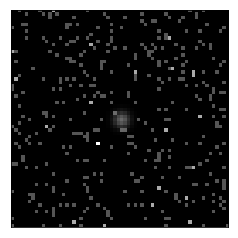

In [0]:
show(data[0,0], vmax = 3)

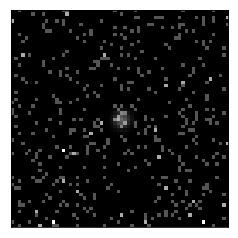

In [0]:
 show(data[0,1], vmax = 3)

# Model

For our model, we use a short UNet with two levels of up- and down- sampling

In [0]:
# Load small UNet From noise2self/models
from models.babyunet import BabyUnet
model = BabyUnet()

In [0]:
from util import getbestgpu
# device = getbestgpu()
device = 0

In [0]:
# Pytorch way of sending model to selected device (GPU or CPU)
model = model.to(device)

# Training

In [0]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch

# Uses pytorch native MSE Loss function and Adam opti with learning rate 3E-4
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.0003)

In [0]:
# Construct a Dataloader from astro data for easy processing
data_loader = DataLoader(data, batch_size=32, shuffle=False)

NameError: ignored

In [0]:
# Main training loop

# Set total number of epochs
n_epochs = 1
for epoch in range(n_epochs):
    for i, batch in enumerate(data_loader):
        # Converts original batch data format to torch tensors
        batch = batch.to(torch.float)
        noisy_images_1, noisy_images_2 = batch[:,0:1], batch[:,1:2]
        # Sends two noisy image samples to device (GPU or CPU)
        noisy_images_1 = noisy_images_1.to(device)
        noisy_images_2 = noisy_images_2.to(device)

        # Baby UNet predictions
        net_output = model(noisy_images_1)

        # MSE Loss for this iteration stored in "loss"
        loss = loss_function(net_output, noisy_images_2)

        # Ensures gradients don't pile on from previous training iterations
        optimizer.zero_grad()

        # Backprop to set gradients for optimizer
        loss.backward()

        # Update Baby UNet parameters
        optimizer.step()

          # Used to track loss as training goes on
          # loss value is in loss.item()
#         if i % 50 == 0:
#             print("Loss (", i, "): \t", round(loss.item(), 4))

In [0]:
# Loads same data int dataloader for testing
test_data_loader = DataLoader(data,
                              batch_size=32,
                              shuffle=False)
# Takes first batch, turns it into torch tensors
i, test_batch = next(enumerate(test_data_loader))
test_batch = test_batch.to(torch.float)
# Takes first 2 noisy images and sends them to GPU/CPU
noisy_images_1, noisy_images_2 = test_batch[:,0:1], test_batch[:,1:2]
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

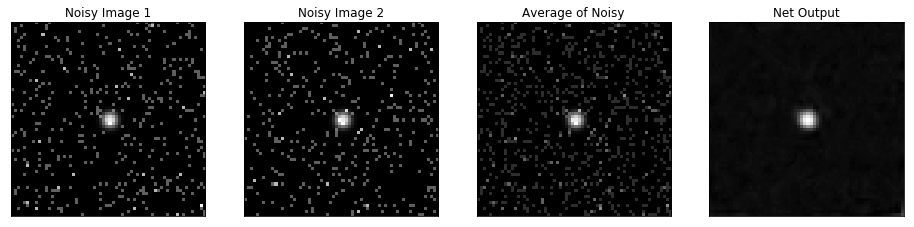

In [0]:
# Predicts noisy image 2 from noisy image 1 
# (.to(device) call is redundant here from previous cell)
output = model(noisy_images_1.to(device)) 
idx = 12
# Handles plotting, as seen below
plot_tensors([noisy_images_1[idx],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

# Real Data

In [0]:
from glob import glob
import os
from collections import defaultdict, Counter
from skimage.io import imread

In [0]:
fnames = glob('../data/cutouts/*.png')

In [0]:
# Read all image files
for file in fnames:
    im = imread(file)
    shapes[im.shape] += 1

In [0]:
# Check to find the most common picture shape
shapes.most_common(3)

[((137, 137), 188), ((137, 120), 3), ((137, 116), 2)]

In [0]:
# Take most common shape to be the default image shape,
# ignore oddly shaped images
shape = shapes.most_common(3)[0][0]

In [0]:
# patches['astro']['physics'] automatically inserts the key 'astro' if it doesn't
# exist, and then maps this to a dictionary, in which 'physics'
# is automatically set to be a key that maps to an empty list
patches = defaultdict(lambda: defaultdict(list))
shapes = Counter()
# Doesn't allow for duplicate bands
bands = set()

# Iterates over filenames to parse information
for file in fnames:
    patch, band, date = os.path.splitext(os.path.basename(file))[0].split('_')
    # Reads file, skips weirdly shaped pictures
    im = imread(file)
    if im.shape != shape:
        continue
    # A patch maps to a dictionary containing bands, which maps to a list of images
    # at that band
    patches[patch][band].append(im)
    bands.add(band)

In [0]:
import numpy as np

In [0]:
print("There are ", len(patches), " patches.")
print("There bands are ", bands, ".")

There are  9  patches.
There bands are  {'i', 'r', 'Y', 'g', 'z'} .


In [0]:
# data = np.stack([(patches[patch]['i'][0], patches[patch]['i'][1]) for patch in patches])

In [0]:
# Joins image 0 and image 1 from each band and each patch along a new axis
data = np.stack([(patches[patch][b][0], patches[patch][b][1]) for patch in patches for b in bands])

In [0]:
clipped_data = data[:,:,:128,:128]/255

In [0]:
# Sets up Baby UNet as in Training section above
model = BabyUnet()
model.to(device)
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.0003)

data_loader = DataLoader(clipped_data, batch_size=9, shuffle=False)

In [0]:
# Predict noisy2 from noisy1

In [0]:
# Main Training Loop
# Operates just as in Training section above
n_epochs = 200

for epoch in range(n_epochs):
    for i, batch in enumerate(data_loader):
        batch = batch.to(torch.float)
        noisy_images_1, noisy_images_2 = batch[:,0:1], batch[:,1:2]
        noisy_images_1 = noisy_images_1.to(device)
        noisy_images_2 = noisy_images_2.to(device)

        net_output = model(noisy_images_1)

        loss = loss_function(net_output, noisy_images_2)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
  
    # Keeps track of loss over 10 epochs
    if epoch % 10 == 0:
        print("Loss (", epoch, "): \t", round(loss.item(), 4))

Loss ( 0 ): 	 0.7171
Loss ( 10 ): 	 0.0445
Loss ( 20 ): 	 0.0358
Loss ( 30 ): 	 0.0337
Loss ( 40 ): 	 0.0328
Loss ( 50 ): 	 0.0323
Loss ( 60 ): 	 0.0319
Loss ( 70 ): 	 0.0317
Loss ( 80 ): 	 0.0314
Loss ( 90 ): 	 0.0313
Loss ( 100 ): 	 0.0312
Loss ( 110 ): 	 0.0311
Loss ( 120 ): 	 0.031
Loss ( 130 ): 	 0.0309
Loss ( 140 ): 	 0.0309
Loss ( 150 ): 	 0.0308
Loss ( 160 ): 	 0.0308
Loss ( 170 ): 	 0.0307
Loss ( 180 ): 	 0.0307
Loss ( 190 ): 	 0.0306


In [0]:
# Sets up test loader, as is done in Training section above
test_data_loader = DataLoader(clipped_data,
                              batch_size=9,
                              shuffle=False)
i, test_batch = next(enumerate(test_data_loader))
test_batch = test_batch.to(torch.float)
noisy_images_1, noisy_images_2 = test_batch[:,0:1], test_batch[:,1:2]
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

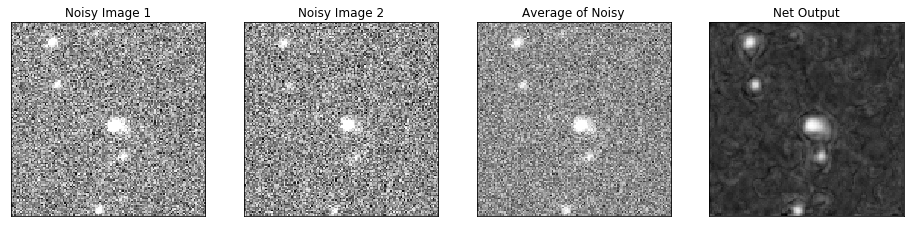

In [0]:
# Predicts noisy image 2 from noisy image 1, denoising the image
# Same as what is done in Training section above  
output = model(noisy_images_1.to(device))
idx = 0
plot_tensors([noisy_images_1[idx],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

# Multichannel Input

In [0]:
# Join first three images in each band for each patch along a new axis
data = np.stack([patches[patch][b][0:3] for patch in patches for b in bands])

In [0]:
clipped_data = data[:,:,:128,:128]/255

In [0]:
clipped_data.shape

(45, 3, 128, 128)

In [0]:
# Constructs two input channel, one output channel Baby UNet
# Previous examples used one in and one out channel
model = BabyUnet(2, 1)
model.to(device)
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.0003)

data_loader = DataLoader(clipped_data, batch_size=9, shuffle=False)

In [0]:
# Nearly the standard Main Training Loop
n_epochs = 200

for epoch in range(n_epochs):
    for i, batch in enumerate(data_loader):
        batch = batch.to(torch.float)
        # noisy_images_1 is now 2 channel, noisy_images_2 is still one channel
        noisy_images_1, noisy_images_2 = batch[:,0:2], batch[:,2:3]
        noisy_images_1 = noisy_images_1.to(device)
        noisy_images_2 = noisy_images_2.to(device)

        net_output = model(noisy_images_1)

        loss = loss_function(net_output, noisy_images_2)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    if epoch % 10 == 0:
        print("Loss (", epoch, "): \t", round(loss.item(), 4))

Loss ( 0 ): 	 0.031
Loss ( 10 ): 	 0.0308
Loss ( 20 ): 	 0.0307
Loss ( 30 ): 	 0.0306
Loss ( 40 ): 	 0.0305
Loss ( 50 ): 	 0.0304
Loss ( 60 ): 	 0.0303
Loss ( 70 ): 	 0.0303
Loss ( 80 ): 	 0.0303
Loss ( 90 ): 	 0.0302
Loss ( 100 ): 	 0.0302
Loss ( 110 ): 	 0.0301
Loss ( 120 ): 	 0.0301
Loss ( 130 ): 	 0.0301
Loss ( 140 ): 	 0.03
Loss ( 150 ): 	 0.03
Loss ( 160 ): 	 0.03
Loss ( 170 ): 	 0.0299
Loss ( 180 ): 	 0.0299
Loss ( 190 ): 	 0.0299


In [0]:
# Same as in Real Data and Training sections above
test_data_loader = DataLoader(clipped_data,
                              batch_size=9,
                              shuffle=False)
i, test_batch = next(enumerate(test_data_loader))
test_batch = test_batch.to(torch.float)
noisy_images_1, noisy_images_2 = test_batch[:,0:2], test_batch[:,2:3]
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)


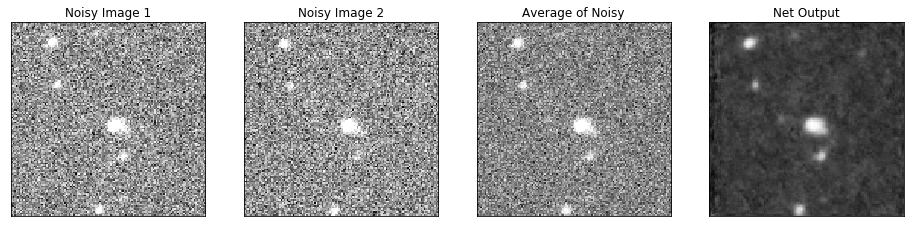

In [0]:
# Nearly the same as Real Data and Training sections above
output = model(noisy_images_1.to(device))
idx = 0
# Have to index into noisy_images_1 because it is two channel
plot_tensors([noisy_images_1[idx][0],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx][0] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

Cyclicly feed the two inputs in.

In [0]:
# Average model predictions from all sets of 2 channels
output = (model(test_batch[:,0:2].to(device)) +
          model(test_batch[:,1:3].to(device)) + 
          model(test_batch[:,np.array([0,2])].to(device)))/3

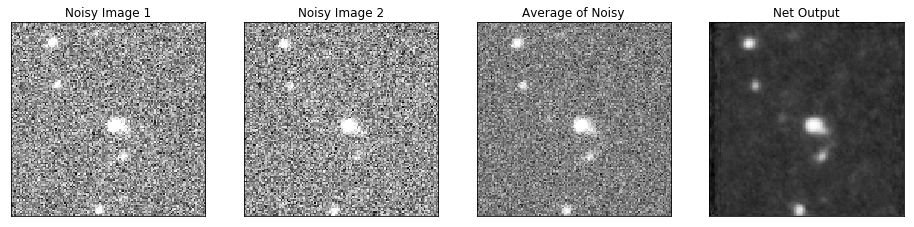

In [0]:
# output = model(noisy_images_1.to(device))
# Plot output averaged over all multichannel combinations
idx = 0
plot_tensors([noisy_images_1[idx][0],
              noisy_images_2[idx],
              (test_batch[0].mean(dim = 0)),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

Compare to classical methods

In [0]:
from skimage.filters import median
from skimage.restoration import denoise_wavelet, denoise_nl_means

/home/batson/miniconda3/envs/pytorch/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


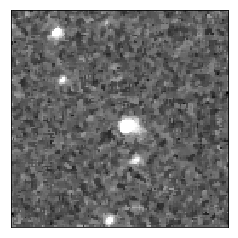

In [0]:
show(median(noisy_images_1[idx][0].cpu().detach().numpy()))

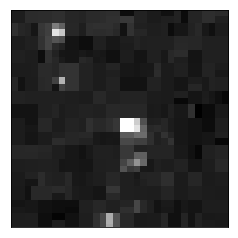

In [0]:
show(denoise_wavelet(noisy_images_1[idx][0].cpu().detach().numpy()))

/home/batson/miniconda3/envs/pytorch/lib/python3.6/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


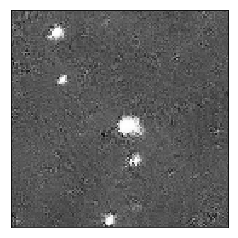

In [0]:
show(denoise_nl_means(noisy_images_1[idx][0].cpu().detach().numpy()))

# Simulated Galaxy Data

In [1]:
!pip install astropy

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from glob import glob
import os
from collections import defaultdict, Counter
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

In [16]:
fnames = glob("../gdrive/My Drive/Noise2Astro/cutouts_v1/*.gz")


['../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_10176.fits.gz', '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_55785.fits.gz', '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_89515.fits.gz', '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_87478.fits.gz', '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_92817.fits.gz', '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_61984.fits.gz', '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_31836.fits.gz', '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_22263.fits.gz', '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_06798.fits.gz', '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_54254.fits.gz', '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_40444.fits.gz', '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_21797.fits.gz', '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_93946.fits.gz', '../gdrive/My Drive/Noise2Astro/cutou

In [21]:
from astropy.io import fits
print(len(fnames))

998


Check out data and pixel values

(12, 128, 128)


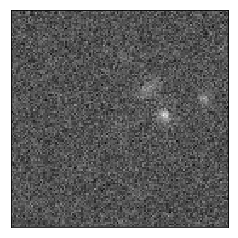

In [0]:
print(np.shape(hdus[0].data))
img = hdus[0].data
show(img[11])

In [0]:
np.max(img[11])

837.7964

(array([3.900e+01, 2.880e+02, 1.812e+03, 4.463e+03, 5.450e+03, 3.215e+03,
        9.290e+02, 1.630e+02, 2.100e+01, 4.000e+00]),
 array([-80.50529  , -61.314625 , -42.123966 , -22.933304 ,  -3.7426438,
         15.448017 ,  34.63868  ,  53.829338 ,  73.02     ,  92.21066  ,
        111.40132  ], dtype=float32),
 <a list of 10 Patch objects>)

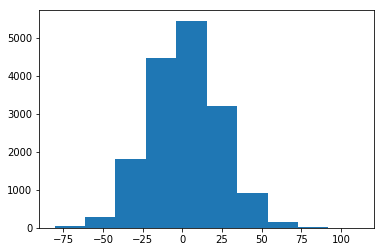

In [0]:
#show(np.clip(img[1], -100,100))
plt.hist(img[1].ravel())

In [0]:
galaxies = {}
# Iterates over filenames to parse information
i = 0
for file in fnames:
    _, _, gal_id = os.path.splitext(os.path.basename(file))[0].split('_')
    gal_id = "gal_" + gal_id.replace('.fits', '')
    hdus = fits.open(file)
    imgs = hdus[0].data
    galaxies[gal_id] = imgs
    i += 1
    print(i)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [0]:
# Joins image 0 and image 1 from each galaxy
data = np.stack([(galaxies[gal_id][0], galaxies[gal_id][1]) for gal_id in galaxies])

In [0]:
clipped_train_data = data[:800,:,:128,:128]/255
clipped_val_data = data[800:900,:,:128,:128]/255
clipped_test_data = data[900:,:,:128,:128]/255

In [0]:
from models.babyunet import BabyUnet
from util import getbestgpu
# device = getbestgpu()
device = 'cuda'
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch

In [0]:
# Sets up Baby UNet as in Training section above
model = BabyUnet()
model.to(device)
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.0003)

train_loader = DataLoader(clipped_train_data, batch_size=9, shuffle=False)
val_loader = DataLoader(clipped_val_data, batch_size=9, shuffle=False)
test_loader = DataLoader(clipped_test_data, batch_size=9, shuffle=False)

In [0]:
# Main Training Loop
# Operates just as in Training section above
n_epochs = 1000
best_loss = 100000

train_losses = []
val_losses = []

best_model={}

for epoch in range(n_epochs):
  
    train_loss = 0
    for i, batch in enumerate(train_loader):
        batch = batch.to(torch.float)
        noisy_images_1, noisy_images_2 = batch[:,0:1], batch[:,1:2]
        print(noisy_images_1.shape)
        noisy_images_1 = noisy_images_1.to(device)
        noisy_images_2 = noisy_images_2.to(device)

        net_output = model(noisy_images_1)

        loss = loss_function(net_output, noisy_images_2)

        train_loss += loss.cpu().item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
    train_losses.append(train_loss/len(train_loader))
    # Keeps track of loss over 10 epochs
    if epoch % 10 == 0:
        print("Loss (", epoch, "): \t", round(loss.item(), 4))
        
    val_loss = 0
    for i, batch in enumerate(val_loader):
        batch = batch.to(torch.float)
        noisy_images_1, noisy_images_2 = batch[:,0:1], batch[:,1:2]
        noisy_images_1 = noisy_images_1.to(device)
        noisy_images_2 = noisy_images_2.to(device)

        net_output = model(noisy_images_1)

        loss = loss_function(net_output, noisy_images_2)  
        val_loss += loss.cpu().item()
        
    val_losses.append(val_loss/len(val_loader))
    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model.state_dict()
      #best_model = torch.save(model.state_dict(), './Model')
        
        
    optimizer.zero_grad()

torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9,

KeyboardInterrupt: ignored

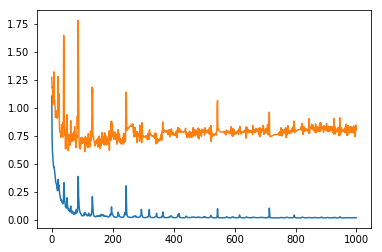

In [0]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)

In [0]:
test_loss = 0
model.load_state_dict(best_model, strict=False)
for i, batch in enumerate(test_loader):
    batch = batch.to(torch.float)
    noisy_images_1, noisy_images_2 = batch[:,0:1], batch[:,1:2]
    print(noisy_images_1.shape)
    noisy_images_1 = noisy_images_1.to(device)
    noisy_images_2 = noisy_images_2.to(device)

    net_output = model(noisy_images_1)

    loss = loss_function(net_output, noisy_images_2)  
    test_loss += loss

print(f'Test Loss: {test_loss/len(test_loader)}')
        
i, test_batch = next(enumerate(test_loader))
test_batch = test_batch.to(torch.float)
noisy_images_1, noisy_images_2 = test_batch[:,0:1], test_batch[:,1:2]
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

AttributeError: ignored

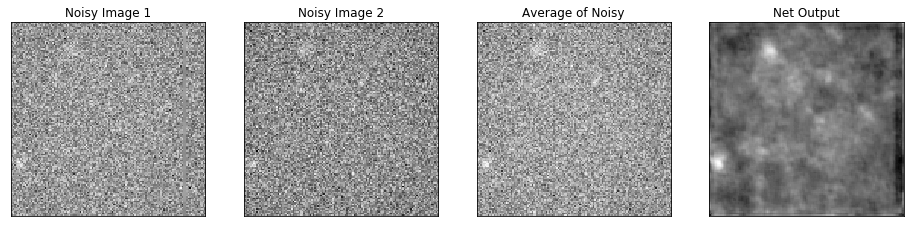

In [0]:
# Predicts noisy image 2 from noisy image 1, denoising the image
# Same as what is done in Training section above  
output = model(noisy_images_1.to(device))
idx = 1
plot_tensors([noisy_images_1[idx],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

(array([6.000e+00, 4.600e+01, 4.620e+02, 2.347e+03, 4.983e+03, 5.267e+03,
        2.530e+03, 6.510e+02, 8.700e+01, 5.000e+00]),
 array([-0.36983904, -0.29357308, -0.21730709, -0.14104111, -0.06477514,
         0.01149084,  0.08775681,  0.16402279,  0.24028876,  0.31655473,
         0.39282072], dtype=float32),
 <a list of 10 Patch objects>)

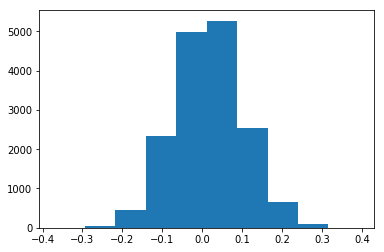

In [0]:
plt.hist(noisy_images_1[idx].cpu().numpy().ravel())

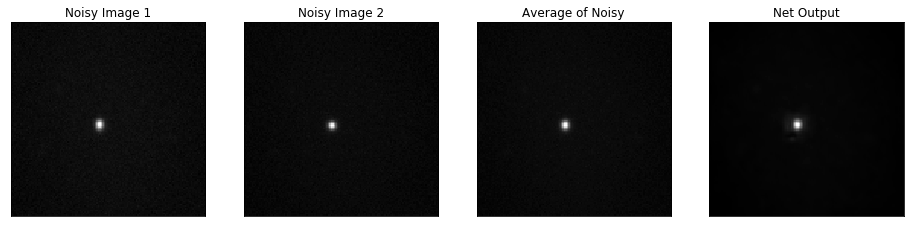

In [0]:
idx = 2
plot_tensors([noisy_images_1[idx],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

(array([1.631e+04, 3.300e+01, 1.400e+01, 7.000e+00, 6.000e+00, 4.000e+00,
        3.000e+00, 2.000e+00, 1.000e+00, 4.000e+00]),
 array([-0.27067053,  0.6973534 ,  1.6653774 ,  2.6334012 ,  3.6014252 ,
         4.569449  ,  5.537473  ,  6.505497  ,  7.4735208 ,  8.441545  ,
         9.409569  ], dtype=float32),
 <a list of 10 Patch objects>)

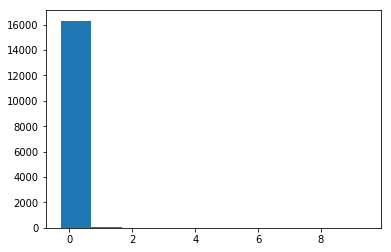

In [0]:
plt.hist(noisy_images_1[idx].cpu().numpy().ravel())

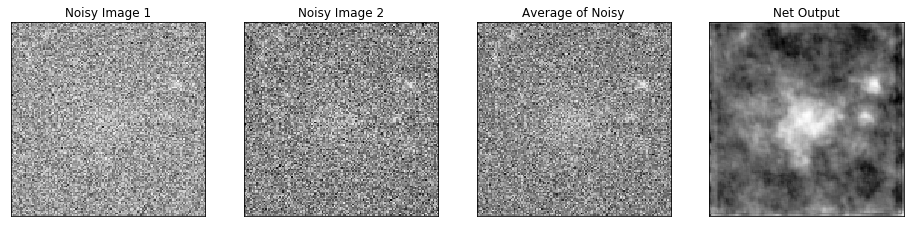

In [0]:
idx = 3
plot_tensors([noisy_images_1[idx],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

(array([5.000e+00, 5.700e+01, 4.240e+02, 2.006e+03, 4.375e+03, 5.049e+03,
        3.225e+03, 1.031e+03, 1.900e+02, 2.200e+01]),
 array([-0.38475078, -0.3096406 , -0.2345304 , -0.1594202 , -0.08431002,
        -0.00919983,  0.06591036,  0.14102055,  0.21613075,  0.29124093,
         0.36635113], dtype=float32),
 <a list of 10 Patch objects>)

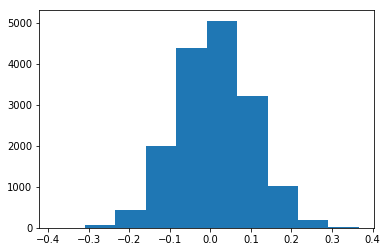

In [0]:
plt.hist(noisy_images_1[idx].cpu().numpy().ravel())

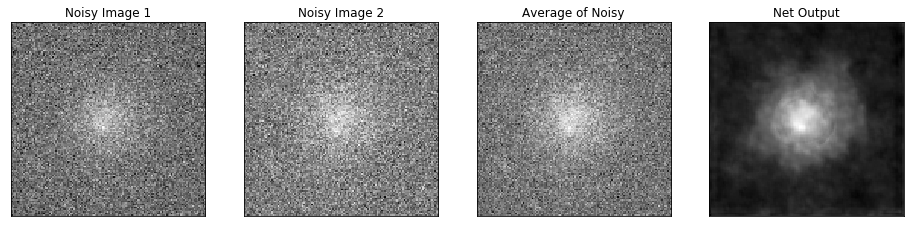

In [0]:
idx = 4
plot_tensors([noisy_images_1[idx],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

(array([4.700e+01, 6.410e+02, 2.988e+03, 5.713e+03, 4.646e+03, 1.856e+03,
        4.160e+02, 6.600e+01, 8.000e+00, 3.000e+00]),
 array([-0.33081546, -0.23578471, -0.14075395, -0.04572319,  0.04930757,
         0.14433832,  0.23936908,  0.33439985,  0.4294306 ,  0.5244613 ,
         0.6194921 ], dtype=float32),
 <a list of 10 Patch objects>)

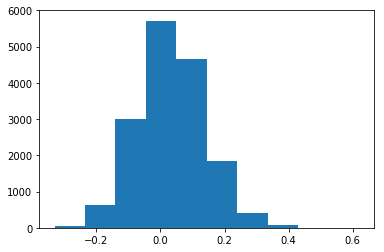

In [0]:
plt.hist(noisy_images_1[idx].cpu().numpy().ravel())

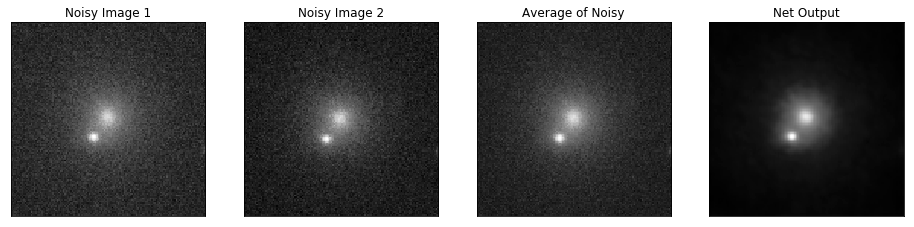

In [0]:
idx = 5
plot_tensors([noisy_images_1[idx],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

(array([9.3200e+02, 1.2218e+04, 2.4130e+03, 4.5300e+02, 2.1500e+02,
        8.7000e+01, 3.7000e+01, 2.0000e+01, 4.0000e+00, 5.0000e+00]),
 array([-0.3692219 , -0.06133237,  0.24655716,  0.5544467 ,  0.8623362 ,
         1.1702257 ,  1.4781153 ,  1.7860048 ,  2.0938942 ,  2.401784  ,
         2.7096734 ], dtype=float32),
 <a list of 10 Patch objects>)

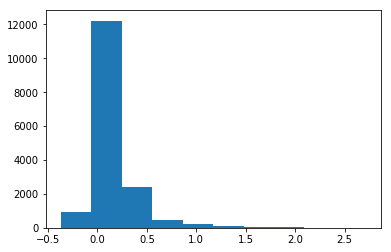

In [0]:
plt.hist(noisy_images_1[idx].cpu().numpy().ravel())

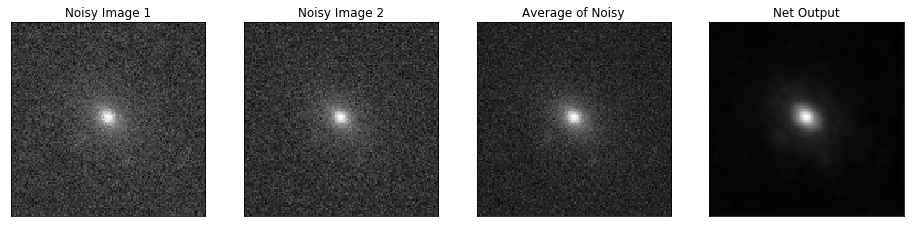

In [0]:
idx = 6
plot_tensors([noisy_images_1[idx],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

(array([5.120e+02, 9.240e+03, 6.061e+03, 4.020e+02, 8.800e+01, 2.700e+01,
        2.600e+01, 1.100e+01, 1.200e+01, 5.000e+00]),
 array([-0.32008836, -0.13252148,  0.05504539,  0.24261226,  0.43017915,
         0.617746  ,  0.8053129 ,  0.99287975,  1.1804466 ,  1.3680135 ,
         1.5555804 ], dtype=float32),
 <a list of 10 Patch objects>)

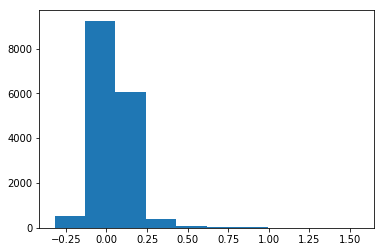

In [0]:
plt.hist(noisy_images_1[idx].cpu().numpy().ravel())

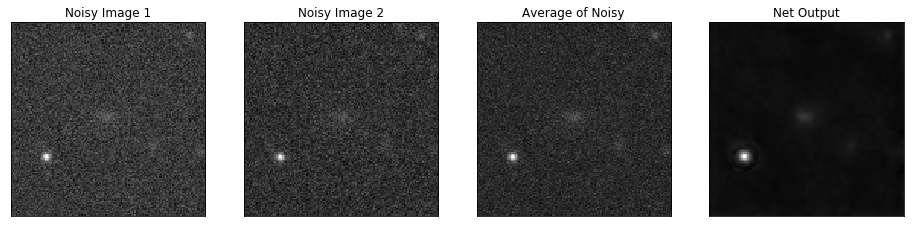

In [0]:
idx = 7
plot_tensors([noisy_images_1[idx],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

(array([4.7300e+02, 1.0132e+04, 5.6440e+03, 1.1200e+02, 5.0000e+00,
        7.0000e+00, 3.0000e+00, 4.0000e+00, 0.0000e+00, 4.0000e+00]),
 array([-0.36951742, -0.16786516,  0.03378711,  0.23543938,  0.43709162,
         0.6387439 ,  0.84039617,  1.0420485 ,  1.2437006 ,  1.4453529 ,
         1.6470052 ], dtype=float32),
 <a list of 10 Patch objects>)

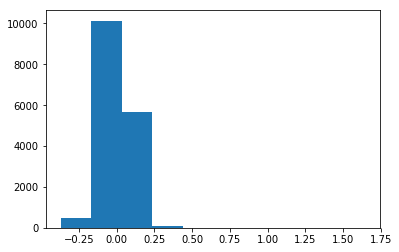

In [0]:
plt.hist(noisy_images_1[idx].cpu().numpy().ravel())

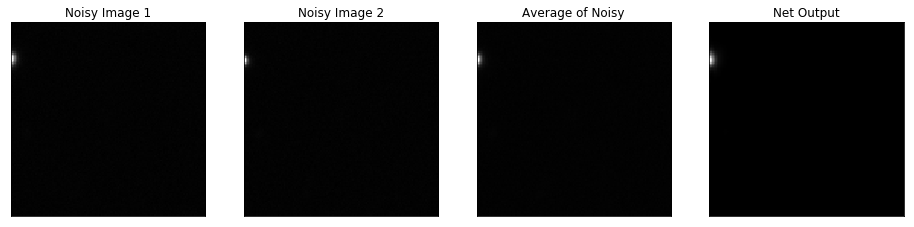

In [0]:
idx = 8
plot_tensors([noisy_images_1[idx],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

(array([1.6344e+04, 1.6000e+01, 6.0000e+00, 7.0000e+00, 3.0000e+00,
        0.0000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([-0.302004 ,  2.4314532,  5.1649103,  7.8983674, 10.6318245,
        13.365282 , 16.09874  , 18.832197 , 21.565653 , 24.29911  ,
        27.032568 ], dtype=float32),
 <a list of 10 Patch objects>)

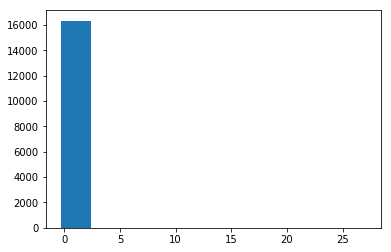

In [0]:
plt.hist(noisy_images_1[idx].cpu().numpy().ravel())

# Simulated Galaxy Data Baseline

In [22]:
!pip install astropy

In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from glob import glob
import os
from collections import defaultdict, Counter
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

In [0]:
fnames = glob("../gdrive/My Drive/Noise2Astro/cutouts_v1/*.gz")

In [26]:
from astropy.io import fits
print(len(fnames))

998


In [29]:
galaxies = {}
# Iterates over filenames to parse information
i = 0
for file in fnames:
    _, _, gal_id = os.path.splitext(os.path.basename(file))[0].split('_')
    gal_id = "gal_" + gal_id.replace('.fits', '')
    hdus = fits.open(file)
    imgs = hdus[0].data
    galaxies[gal_id] = imgs
    i += 1
    if i % 50 == 49:
      print((i + .0)/len(fnames))

0.04909819639278557
0.09919839679358718
0.1492985971943888
0.19939879759519039
0.24949899799599198
0.2995991983967936
0.3496993987975952
0.3997995991983968
0.4498997995991984
0.5
0.5501002004008017
0.6002004008016032
0.6503006012024048
0.7004008016032064
0.750501002004008
0.8006012024048096
0.8507014028056112
0.9008016032064128
0.9509018036072144


In [0]:
# Joins image 0 and image 1 from each galaxy
data = np.stack([(galaxies[gal_id][0], galaxies[gal_id][1]) for gal_id in galaxies])

In [0]:
clipped_train_data = data[:800,:,:128,:128]/255
clipped_val_data = data[800:900,:,:128,:128]/255
clipped_test_data = data[900:,:,:128,:128]/255

In [0]:
from models.singleconv import SingleConvolution
from util import getbestgpu
# device = getbestgpu()
device = 'cuda'
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch

In [0]:
# Sets up Baby UNet as in Training section above
model = SingleConvolution()
model.to(device)
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.00005)

train_loader = DataLoader(clipped_train_data, batch_size=9, shuffle=False)
val_loader = DataLoader(clipped_val_data, batch_size=9, shuffle=False)
test_loader = DataLoader(clipped_test_data, batch_size=9, shuffle=False)

In [62]:
# Main Training Loop
# Operates just as in Training section above
# Loss accounted for in a per epoch basis
n_epochs = 1200
best_loss = 100000

train_losses = []
val_losses = []

best_model={}

for epoch in range(n_epochs):
  
    train_loss = 0
    for i, batch in enumerate(train_loader):
        batch = batch.to(torch.float)
        noisy_images_1, noisy_images_2 = batch[:,0:1], batch[:,1:2]
        noisy_images_1 = noisy_images_1.to(device)
        noisy_images_2 = noisy_images_2.to(device)

        net_output = model(noisy_images_1)

        loss = loss_function(net_output, noisy_images_2)

        train_loss += loss.cpu().item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
    train_losses.append(train_loss/len(train_loader))
    
    # Keeps track of loss over 10 epochs
    if epoch % 10 == 0:
        print("Loss (", epoch, "): \t", round(loss.item(), 4))
        
    val_loss = 0
    for i, batch in enumerate(val_loader):
        batch = batch.to(torch.float)
        noisy_images_1, noisy_images_2 = batch[:,0:1], batch[:,1:2]
        noisy_images_1 = noisy_images_1.to(device)
        noisy_images_2 = noisy_images_2.to(device)

        net_output = model(noisy_images_1)

        loss = loss_function(net_output, noisy_images_2)  
        val_loss += loss.cpu().item()
        
    val_losses.append(val_loss/len(val_loader))
    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model.state_dict()        
        
    optimizer.zero_grad()
    
torch.save(best_model, '../gdrive/My Drive/Noise2Astro/baseline_model')


Loss ( 0 ): 	 0.1614
Loss ( 10 ): 	 0.1374
Loss ( 20 ): 	 0.1189
Loss ( 30 ): 	 0.1045
Loss ( 40 ): 	 0.0935
Loss ( 50 ): 	 0.0855
Loss ( 60 ): 	 0.08
Loss ( 70 ): 	 0.0765
Loss ( 80 ): 	 0.0745
Loss ( 90 ): 	 0.0735
Loss ( 100 ): 	 0.0727
Loss ( 110 ): 	 0.0721
Loss ( 120 ): 	 0.0715
Loss ( 130 ): 	 0.071
Loss ( 140 ): 	 0.0705
Loss ( 150 ): 	 0.07
Loss ( 160 ): 	 0.0696
Loss ( 170 ): 	 0.0691
Loss ( 180 ): 	 0.0687
Loss ( 190 ): 	 0.0684
Loss ( 200 ): 	 0.068
Loss ( 210 ): 	 0.0677
Loss ( 220 ): 	 0.0674
Loss ( 230 ): 	 0.0671
Loss ( 240 ): 	 0.0669
Loss ( 250 ): 	 0.0666
Loss ( 260 ): 	 0.0664
Loss ( 270 ): 	 0.0662
Loss ( 280 ): 	 0.066
Loss ( 290 ): 	 0.0658
Loss ( 300 ): 	 0.0656
Loss ( 310 ): 	 0.0655
Loss ( 320 ): 	 0.0653
Loss ( 330 ): 	 0.0652
Loss ( 340 ): 	 0.065
Loss ( 350 ): 	 0.0649
Loss ( 360 ): 	 0.0648
Loss ( 370 ): 	 0.0647
Loss ( 380 ): 	 0.0646
Loss ( 390 ): 	 0.0645
Loss ( 400 ): 	 0.0644
Loss ( 410 ): 	 0.0643
Loss ( 420 ): 	 0.0643
Loss ( 430 ): 	 0.0642
Loss ( 

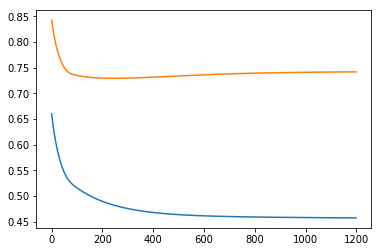

In [63]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)

In [69]:
test_loss = 0
model.load_state_dict(best_model, strict=False)
for i, batch in enumerate(test_loader):
    batch = batch.to(torch.float)
    noisy_images_1, noisy_images_2 = batch[:,0:1], batch[:,1:2]
    noisy_images_1 = noisy_images_1.to(device)
    noisy_images_2 = noisy_images_2.to(device)

    net_output = model(noisy_images_1)

    loss = loss_function(net_output, noisy_images_2)  
    test_loss += loss

print(f'Test Loss: {test_loss/len(test_loader)}')
i, test_batch = next(enumerate(test_loader))
test_batch = test_batch.to(torch.float)
noisy_images_1, noisy_images_2 = test_batch[:,0:1], test_batch[:,1:2]
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

Test Loss: 0.0656137689948082


Baseline Achieves                  

1.   Train Loss of .0633
2.   Validation Loss ~.74
3.   Test Loss of 0.0656137689948082   



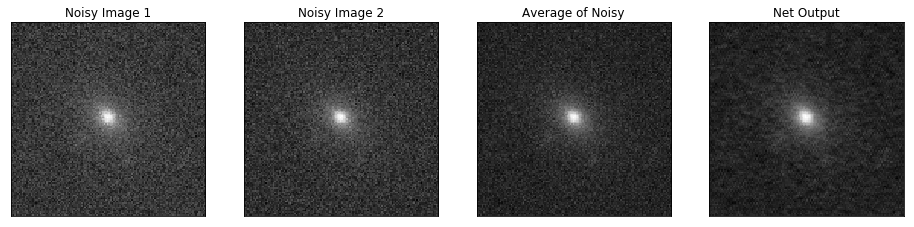

In [74]:
# Predicts noisy image 2 from noisy image 1, denoising the image
# Same as what is done in Training section above  
output = model(noisy_images_1.to(device))
idx = 6
plot_tensors([noisy_images_1[idx],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

# Multi-Channel Input

In [0]:
!pip install astropy

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from glob import glob
import os
from collections import defaultdict, Counter
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from astropy.io import fits
from torch import Tensor

In [0]:
class MultiChannelGalaxyDataset(Dataset):
  """MultiChannel Dataset"""
  
  def __init__(self, type):
    self.fnames = glob("../gdrive/My Drive/Noise2Astro/cutouts_v1/*.gz")
    self.data = self._load_data(type)
    self.type = type
    
  def __len__(self):
    if self.type == "train":
      return 800
    elif self.type == "validate":
      return 100
    else:
      return 98
  
  def _load_data(self, type):
    galaxies = []
    if type == "train":
      for i in range(800):
        galaxies.append(Tensor(fits.open(self.fnames[i])[0].data[:,:128,:128]/255))
        if i % 10 == 0:
          print(f'{i/800} Done')
    
    elif type == "validate":
      for i in range(800, 900):
        galaxies.append(Tensor(fits.open(self.fnames[i])[0].data[:,:128,:128]/255))
        if i % 10 == 0:
          print(f'{(i - 800)/100} Done')

    elif type == "test":
      for i in range(900, 998):
        galaxies.append(Tensor(fits.open(self.fnames[i])[0].data[:,:128,:128]/255))
        if i % 10 == 0:
          print(f'{(i - 900)/97} Done')

    return galaxies
  
  def __getitem__(self, idx):
    channels = self.data[idx]
    idx1 = np.random.randint(0, len(channels))
    idx2 = idx1
    while idx2 == idx1:
      idx2 = np.random.randint(0, len(channels))
    
    return channels[idx1].unsqueeze(0), channels[idx2].unsqueeze(0)
  
  def get_full_batch(self, idx):
    return self.data[idx]    

In [0]:
train_data = MultiChannelGalaxyDataset("train")
val_data = MultiChannelGalaxyDataset("validate")
test_data = MultiChannelGalaxyDataset("test")

0.0 Done
0.0125 Done
0.025 Done
0.0375 Done
0.05 Done
0.0625 Done
0.075 Done
0.0875 Done
0.1 Done
0.1125 Done
0.125 Done
0.1375 Done
0.15 Done
0.1625 Done
0.175 Done
0.1875 Done
0.2 Done
0.2125 Done
0.225 Done
0.2375 Done
0.25 Done
0.2625 Done
0.275 Done
0.2875 Done
0.3 Done
0.3125 Done
0.325 Done
0.3375 Done
0.35 Done
0.3625 Done
0.375 Done
0.3875 Done
0.4 Done
0.4125 Done
0.425 Done
0.4375 Done
0.45 Done
0.4625 Done
0.475 Done
0.4875 Done
0.5 Done
0.5125 Done
0.525 Done
0.5375 Done
0.55 Done
0.5625 Done
0.575 Done
0.5875 Done
0.6 Done
0.6125 Done
0.625 Done
0.6375 Done
0.65 Done
0.6625 Done
0.675 Done
0.6875 Done
0.7 Done
0.7125 Done
0.725 Done
0.7375 Done
0.75 Done
0.7625 Done
0.775 Done
0.7875 Done
0.8 Done
0.8125 Done
0.825 Done
0.8375 Done
0.85 Done
0.8625 Done
0.875 Done
0.8875 Done
0.9 Done
0.9125 Done
0.925 Done
0.9375 Done
0.95 Done
0.9625 Done
0.975 Done
0.9875 Done
0.0 Done
0.1 Done
0.2 Done
0.3 Done
0.4 Done
0.5 Done
0.6 Done
0.7 Done
0.8 Done
0.9 Done
0.0 Done
0.103092783

In [0]:
from models.babyunet import BabyUnet
from util import getbestgpu
# device = getbestgpu()
device = 'cuda'
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch

In [0]:
# Sets up Baby UNet as in Training section above
model = BabyUnet()
model.to(device)
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.0003)

train_loader = DataLoader(train_data, batch_size=9, shuffle=False)
val_loader = DataLoader(val_data, batch_size=9, shuffle=False)
test_loader = DataLoader(test_data, batch_size=9, shuffle=False)

In [0]:
# Main Training Loop
# Operates just as in Training section above
n_epochs = 1200
best_loss = 100000

train_losses = []
val_losses = []

best_model={}

for epoch in range(n_epochs):
  
    train_loss = 0
    for i, batch in enumerate(train_loader):
        noisy_images_1, noisy_images_2 = Tensor(batch[:][0]), Tensor(batch[:][1])
        noisy_images_1 = noisy_images_1.to(device)
        noisy_images_2 = noisy_images_2.to(device)

        net_output = model(noisy_images_1)

        #if i == 3:
         # print(net_output.cpu().detach().numpy()[2:3].squeeze(0).squeeze(0).shape)
          #plt.imshow(net_output.cpu().detach().numpy()[2:3].squeeze(0).squeeze(0), cmap="gray")
        loss = loss_function(net_output, noisy_images_2)

        train_loss += loss.cpu().item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
    train_losses.append(train_loss/len(train_loader))
    # Keeps track of loss over 10 epochs
    if epoch % 10 == 0:
        print("Loss (", epoch, "): \t", round(loss.item(), 4))
        
    val_loss = 0
    for i, batch in enumerate(val_loader):
        noisy_images_1, noisy_images_2 = Tensor(batch[:][0]), Tensor(batch[:][1])
        noisy_images_1 = noisy_images_1.to(device)
        noisy_images_2 = noisy_images_2.to(device)

        net_output = model(noisy_images_1)

        loss = loss_function(net_output, noisy_images_2)  
        val_loss += loss.cpu().item()
        
    val_losses.append(val_loss/len(val_loader))
    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model.state_dict()
          
    optimizer.zero_grad()

Loss ( 0 ): 	 0.706
Loss ( 10 ): 	 0.4078
Loss ( 20 ): 	 0.4446
Loss ( 30 ): 	 35.4064
Loss ( 40 ): 	 1.0151
Loss ( 50 ): 	 0.4121
Loss ( 60 ): 	 1.2296
Loss ( 70 ): 	 0.316
Loss ( 80 ): 	 0.6951
Loss ( 90 ): 	 0.2473
Loss ( 100 ): 	 0.1578
Loss ( 110 ): 	 0.3201
Loss ( 120 ): 	 7.9601
Loss ( 130 ): 	 0.8453
Loss ( 140 ): 	 12.8953
Loss ( 150 ): 	 0.8033
Loss ( 160 ): 	 1.2415
Loss ( 170 ): 	 0.0966
Loss ( 180 ): 	 34.899
Loss ( 190 ): 	 0.2653
Loss ( 200 ): 	 0.7023
Loss ( 210 ): 	 0.1606
Loss ( 220 ): 	 0.783
Loss ( 230 ): 	 1.6523
Loss ( 240 ): 	 0.2705
Loss ( 250 ): 	 0.3427
Loss ( 260 ): 	 13.469
Loss ( 270 ): 	 0.2166
Loss ( 280 ): 	 0.2728
Loss ( 290 ): 	 0.3452
Loss ( 300 ): 	 0.5882
Loss ( 310 ): 	 0.3392
Loss ( 320 ): 	 34.0875
Loss ( 330 ): 	 0.236
Loss ( 340 ): 	 34.9591
Loss ( 350 ): 	 0.7744
Loss ( 360 ): 	 0.5674
Loss ( 370 ): 	 0.2165
Loss ( 380 ): 	 0.6271
Loss ( 390 ): 	 1.6324
Loss ( 400 ): 	 0.1872
Loss ( 410 ): 	 0.5567
Loss ( 420 ): 	 0.2224
Loss ( 430 ): 	 0.3215

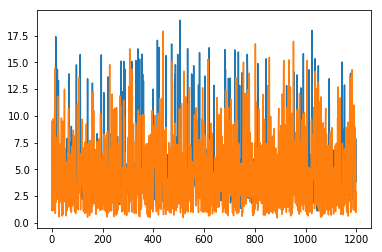

In [0]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)

In [0]:
torch.save(model.state_dict(), "../multichannel_model")

In [0]:
test_loss = 0
model.load_state_dict(best_model, strict=False)
for i, batch in enumerate(test_loader):
    noisy_images_1, noisy_images_2 = Tensor(batch[:][0]), Tensor(batch[:][1])
    noisy_images_1 = noisy_images_1.to(device)
    noisy_images_2 = noisy_images_2.to(device)

    net_output = model(noisy_images_1)
    loss = loss_function(net_output, noisy_images_2)  
    test_loss += loss

print(f'Test Loss: {test_loss/len(test_loader)}')

Test Loss: 0.659989595413208


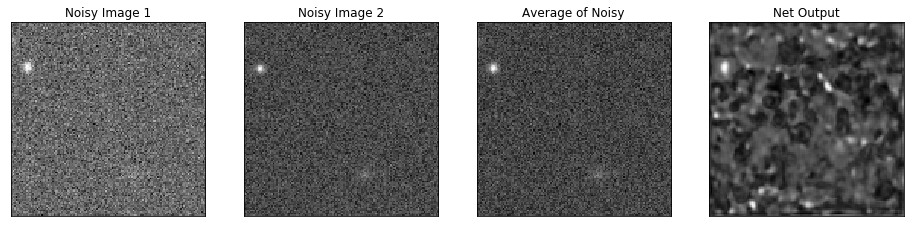

In [0]:
# Predicts noisy image 2 from noisy image 1, denoising the image
# Same as what is done in Training section above  
channels = test_data.get_full_batch(0)

noisy_images_1, noisy_images_2 = Tensor(channels[0]).unsqueeze(0).unsqueeze(0), Tensor(channels[1]).unsqueeze(0).unsqueeze(0)
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

output = model(noisy_images_1)
plot_tensors([noisy_images_1,
              noisy_images_2,
              0.5*(noisy_images_1 + noisy_images_2),
              output],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])


(array([ 793., 6631., 6810., 1628.,  344.,   92.,   45.,   18.,   16.,
           7.]),
 array([-0.24444288,  0.04177423,  0.32799134,  0.61420846,  0.90042555,
         1.1866426 ,  1.4728597 ,  1.759077  ,  2.045294  ,  2.331511  ,
         2.6177282 ], dtype=float32),
 <a list of 10 Patch objects>)

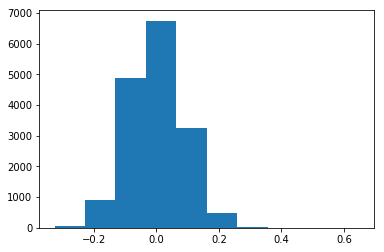

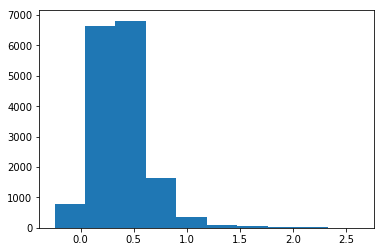

In [0]:
plt.hist(noisy_images_1.cpu().numpy().ravel())
plt.figure()
plt.hist(output.detach().cpu().numpy().ravel())

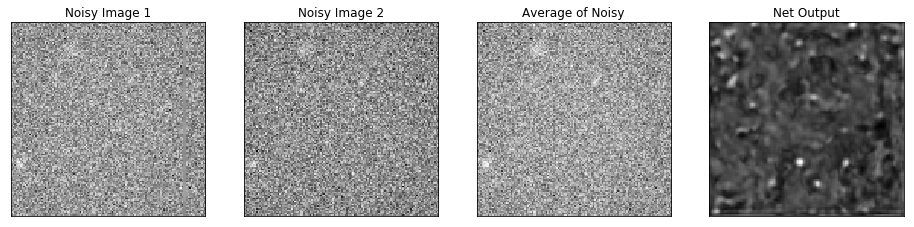

In [0]:
# Predicts noisy image 2 from noisy image 1, denoising the image
# Same as what is done in Training section above  
channels = test_data.get_full_batch(1)

noisy_images_1, noisy_images_2 = Tensor(channels[0]).unsqueeze(0).unsqueeze(0), Tensor(channels[1]).unsqueeze(0).unsqueeze(0)
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

output = model(noisy_images_1)
plot_tensors([noisy_images_1,
              noisy_images_2,
              0.5*(noisy_images_1 + noisy_images_2),
              output],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

(array([3.690e+02, 6.819e+03, 7.752e+03, 1.102e+03, 2.060e+02, 8.800e+01,
        2.900e+01, 7.000e+00, 7.000e+00, 5.000e+00]),
 array([-0.37532145,  0.0075793 ,  0.39048004,  0.77338076,  1.1562815 ,
         1.5391823 ,  1.922083  ,  2.3049839 ,  2.6878846 ,  3.0707853 ,
         3.453686  ], dtype=float32),
 <a list of 10 Patch objects>)

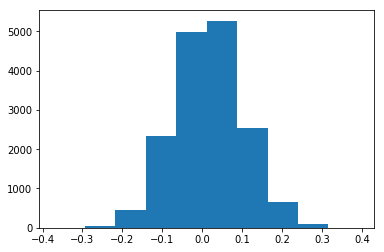

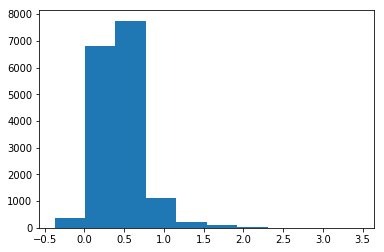

In [0]:
plt.hist(noisy_images_1.cpu().numpy().ravel())
plt.figure()
plt.hist(output.detach().cpu().numpy().ravel())

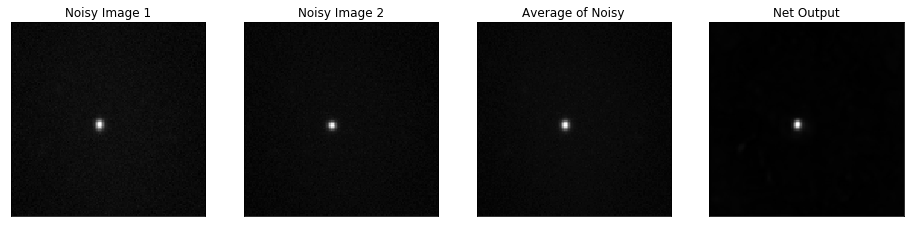

In [0]:
# Predicts noisy image 2 from noisy image 1, denoising the image
# Same as what is done in Training section above  
channels = test_data.get_full_batch(2)

noisy_images_1, noisy_images_2 = Tensor(channels[0]).unsqueeze(0).unsqueeze(0), Tensor(channels[1]).unsqueeze(0).unsqueeze(0)
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

output = model(noisy_images_1)
plot_tensors([noisy_images_1,
              noisy_images_2,
              0.5*(noisy_images_1 + noisy_images_2),
              output],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

(array([1.6335e+04, 1.9000e+01, 9.0000e+00, 6.0000e+00, 2.0000e+00,
        3.0000e+00, 5.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([-0.09605487,  3.2532117 ,  6.602478  ,  9.951745  , 13.301011  ,
        16.650278  , 19.999544  , 23.34881   , 26.698078  , 30.047344  ,
        33.39661   ], dtype=float32),
 <a list of 10 Patch objects>)

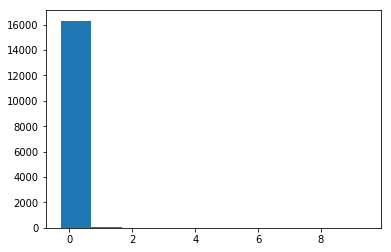

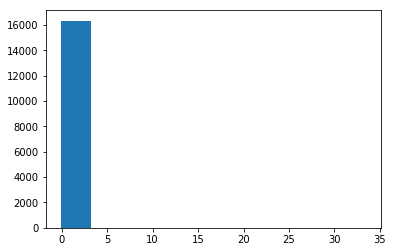

In [0]:
plt.hist(noisy_images_1.cpu().numpy().ravel())
plt.figure()
plt.hist(output.detach().cpu().numpy().ravel())

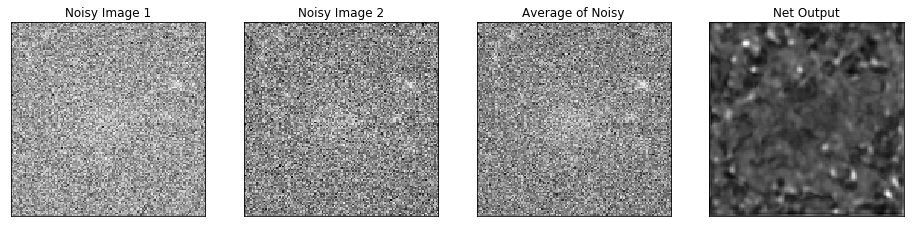

In [0]:
# Predicts noisy image 2 from noisy image 1, denoising the image
# Same as what is done in Training section above  
channels = test_data.get_full_batch(3)

noisy_images_1, noisy_images_2 = Tensor(channels[0]).unsqueeze(0).unsqueeze(0), Tensor(channels[1]).unsqueeze(0).unsqueeze(0)
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

output = model(noisy_images_1)
plot_tensors([noisy_images_1,
              noisy_images_2,
              0.5*(noisy_images_1 + noisy_images_2),
              output],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

(array([2.010e+02, 5.123e+03, 8.732e+03, 1.819e+03, 3.390e+02, 1.140e+02,
        2.900e+01, 1.700e+01, 5.000e+00, 5.000e+00]),
 array([-0.39727634, -0.02661778,  0.34404078,  0.7146993 ,  1.0853579 ,
         1.4560164 ,  1.826675  ,  2.1973336 ,  2.5679922 ,  2.9386506 ,
         3.3093092 ], dtype=float32),
 <a list of 10 Patch objects>)

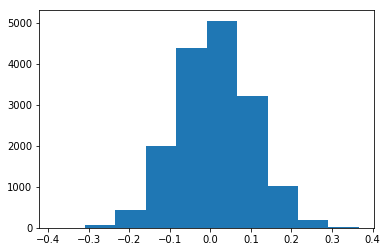

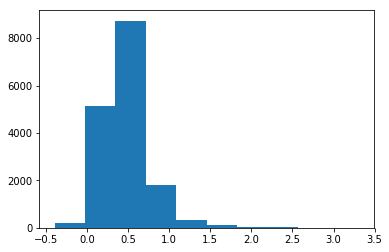

In [0]:
plt.hist(noisy_images_1.cpu().numpy().ravel())
plt.figure()
plt.hist(output.detach().cpu().numpy().ravel())

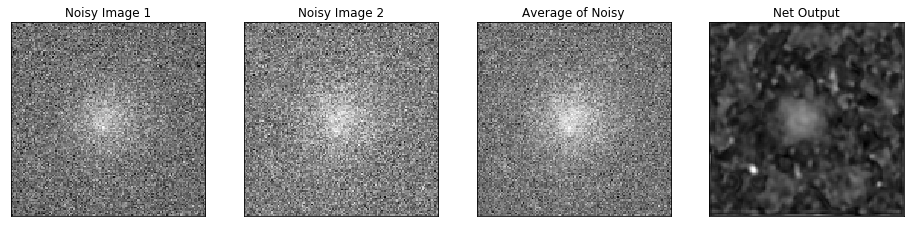

In [0]:
# Predicts noisy image 2 from noisy image 1, denoising the image
# Same as what is done in Training section above  
channels = test_data.get_full_batch(4)

noisy_images_1, noisy_images_2 = Tensor(channels[0]).unsqueeze(0).unsqueeze(0), Tensor(channels[1]).unsqueeze(0).unsqueeze(0)
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

output = model(noisy_images_1)
plot_tensors([noisy_images_1,
              noisy_images_2,
              0.5*(noisy_images_1 + noisy_images_2),
              output],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

(array([1.612e+03, 9.362e+03, 4.486e+03, 6.930e+02, 2.070e+02, 1.200e+01,
        3.000e+00, 3.000e+00, 3.000e+00, 3.000e+00]),
 array([-0.16285488,  0.14927295,  0.46140078,  0.7735286 ,  1.0856564 ,
         1.3977842 ,  1.7099121 ,  2.02204   ,  2.3341677 ,  2.6462955 ,
         2.9584234 ], dtype=float32),
 <a list of 10 Patch objects>)

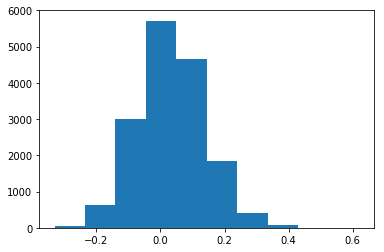

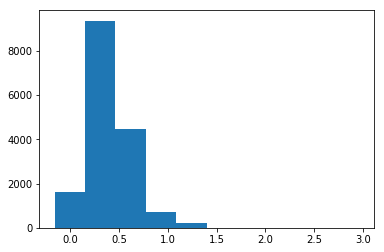

In [0]:
plt.hist(noisy_images_1.cpu().numpy().ravel())
plt.figure()
plt.hist(output.detach().cpu().numpy().ravel())

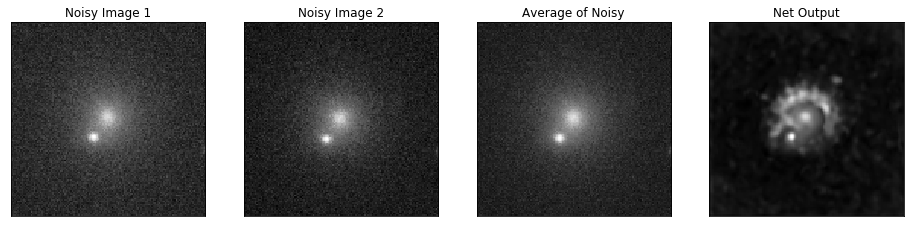

In [0]:
# Predicts noisy image 2 from noisy image 1, denoising the image
# Same as what is done in Training section above  
channels = test_data.get_full_batch(5)

noisy_images_1, noisy_images_2 = Tensor(channels[0]).unsqueeze(0).unsqueeze(0), Tensor(channels[1]).unsqueeze(0).unsqueeze(0)
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

output = model(noisy_images_1)
plot_tensors([noisy_images_1,
              noisy_images_2,
              0.5*(noisy_images_1 + noisy_images_2),
              output],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

(array([1.3919e+04, 1.1500e+03, 5.0900e+02, 3.4800e+02, 2.6900e+02,
        1.2700e+02, 4.2000e+01, 1.6000e+01, 2.0000e+00, 2.0000e+00]),
 array([-0.20123728,  0.50104594,  1.2033291 ,  1.9056123 ,  2.6078956 ,
         3.3101788 ,  4.012462  ,  4.714745  ,  5.4170284 ,  6.1193113 ,
         6.8215947 ], dtype=float32),
 <a list of 10 Patch objects>)

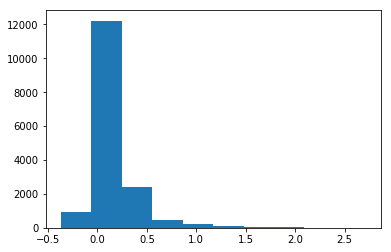

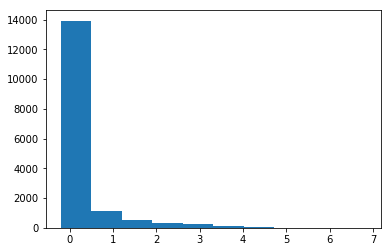

In [0]:
plt.hist(noisy_images_1.cpu().numpy().ravel())
plt.figure()
plt.hist(output.detach().cpu().numpy().ravel())

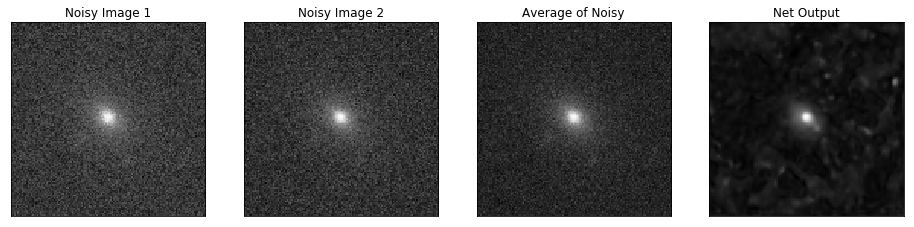

In [0]:
# Predicts noisy image 2 from noisy image 1, denoising the image
# Same as what is done in Training section above  
channels = test_data.get_full_batch(6)

noisy_images_1, noisy_images_2 = Tensor(channels[0]).unsqueeze(0).unsqueeze(0), Tensor(channels[1]).unsqueeze(0).unsqueeze(0)
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

output = model(noisy_images_1)
plot_tensors([noisy_images_1,
              noisy_images_2,
              0.5*(noisy_images_1 + noisy_images_2),
              output],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

(array([1.3438e+04, 2.6900e+03, 1.4900e+02, 5.6000e+01, 2.0000e+01,
        8.0000e+00, 8.0000e+00, 5.0000e+00, 6.0000e+00, 4.0000e+00]),
 array([-0.20532256,  0.4310997 ,  1.067522  ,  1.7039443 ,  2.3403666 ,
         2.9767888 ,  3.6132112 ,  4.2496333 ,  4.8860555 ,  5.522478  ,
         6.1589003 ], dtype=float32),
 <a list of 10 Patch objects>)

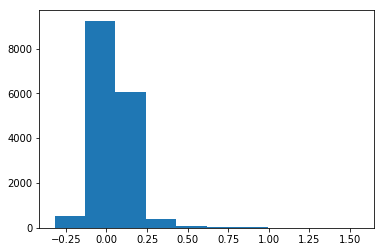

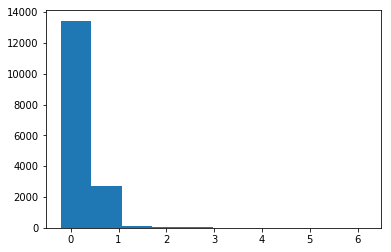

In [0]:
plt.hist(noisy_images_1.cpu().numpy().ravel())
plt.figure()
plt.hist(output.detach().cpu().numpy().ravel())

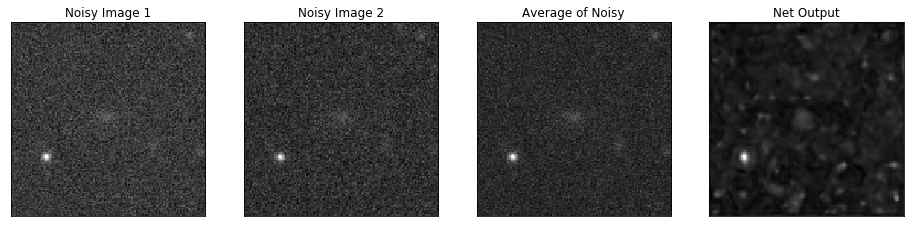

In [0]:
# Predicts noisy image 2 from noisy image 1, denoising the image
# Same as what is done in Training section above  
channels = test_data.get_full_batch(7)

noisy_images_1, noisy_images_2 = Tensor(channels[0]).unsqueeze(0).unsqueeze(0), Tensor(channels[1]).unsqueeze(0).unsqueeze(0)
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

output = model(noisy_images_1)
plot_tensors([noisy_images_1,
              noisy_images_2,
              0.5*(noisy_images_1 + noisy_images_2),
              output],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

(array([9.489e+03, 6.656e+03, 1.930e+02, 2.300e+01, 7.000e+00, 5.000e+00,
        4.000e+00, 2.000e+00, 1.000e+00, 4.000e+00]),
 array([-0.2810753 ,  0.25662944,  0.7943342 ,  1.3320389 ,  1.8697436 ,
         2.4074483 ,  2.9451532 ,  3.482858  ,  4.0205626 ,  4.558267  ,
         5.095972  ], dtype=float32),
 <a list of 10 Patch objects>)

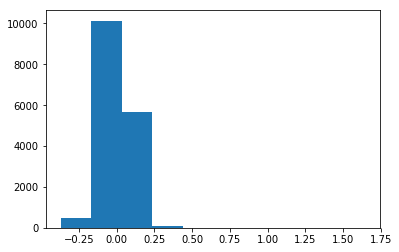

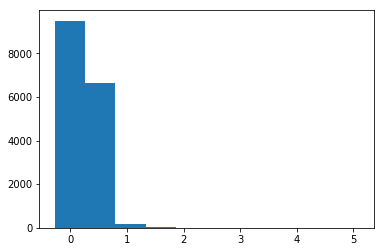

In [0]:
plt.hist(noisy_images_1.cpu().numpy().ravel())
plt.figure()
plt.hist(output.detach().cpu().numpy().ravel())

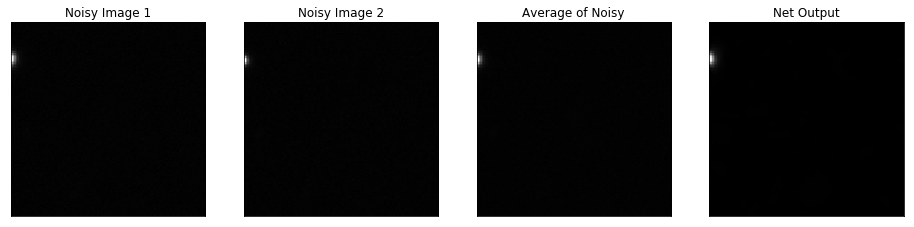

In [0]:
# Predicts noisy image 2 from noisy image 1, denoising the image
# Same as what is done in Training section above  
channels = test_data.get_full_batch(8)

noisy_images_1, noisy_images_2 = Tensor(channels[0]).unsqueeze(0).unsqueeze(0), Tensor(channels[1]).unsqueeze(0).unsqueeze(0)
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

output = model(noisy_images_1)
plot_tensors([noisy_images_1,
              noisy_images_2,
              0.5*(noisy_images_1 + noisy_images_2),
              output],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

(array([1.6338e+04, 1.7000e+01, 9.0000e+00, 4.0000e+00, 5.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00]),
 array([ 0.08709326,  5.221003  , 10.354914  , 15.488823  , 20.622734  ,
        25.756643  , 30.890553  , 36.024464  , 41.158375  , 46.292282  ,
        51.426193  ], dtype=float32),
 <a list of 10 Patch objects>)

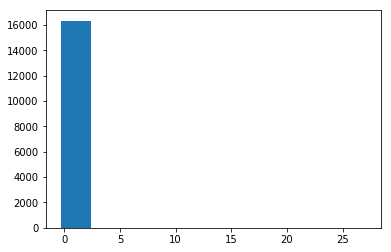

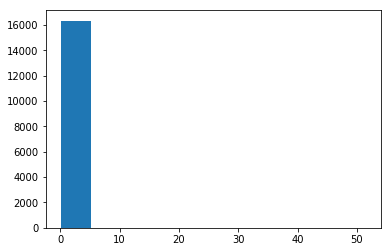

In [0]:
plt.hist(noisy_images_1.cpu().numpy().ravel())
plt.figure()
plt.hist(output.detach().cpu().numpy().ravel())

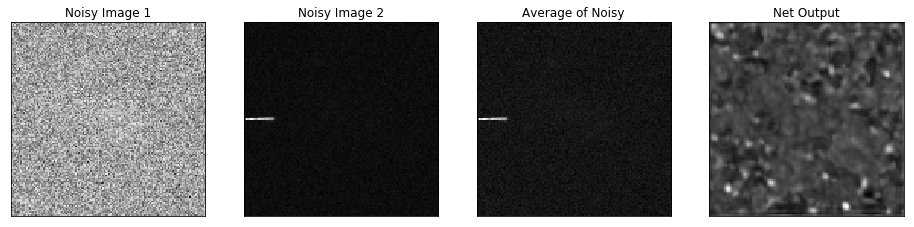

In [0]:
# Predicts noisy image 2 from noisy image 1, denoising the image
# Same as what is done in Training section above  
channels = test_data.get_full_batch(9)

noisy_images_1, noisy_images_2 = Tensor(channels[0]).unsqueeze(0).unsqueeze(0), Tensor(channels[1]).unsqueeze(0).unsqueeze(0)
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

output = model(noisy_images_1)
plot_tensors([noisy_images_1,
              noisy_images_2,
              0.5*(noisy_images_1 + noisy_images_2),
              output],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

(array([1.820e+02, 6.955e+03, 8.043e+03, 8.710e+02, 2.010e+02, 8.300e+01,
        3.300e+01, 7.000e+00, 7.000e+00, 2.000e+00]),
 array([-0.5394723 , -0.06595986,  0.40755257,  0.881065  ,  1.3545774 ,
         1.8280898 ,  2.3016024 ,  2.7751148 ,  3.2486272 ,  3.7221396 ,
         4.195652  ], dtype=float32),
 <a list of 10 Patch objects>)

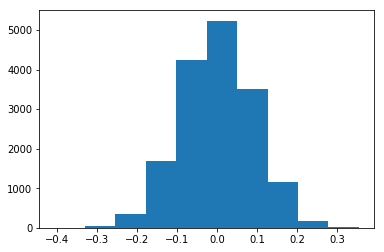

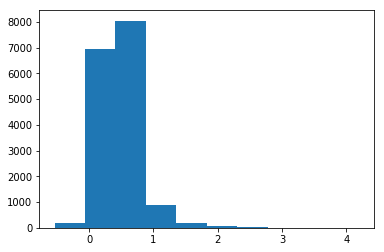

In [0]:
plt.hist(noisy_images_1.cpu().numpy().ravel())
plt.figure()
plt.hist(output.detach().cpu().numpy().ravel())

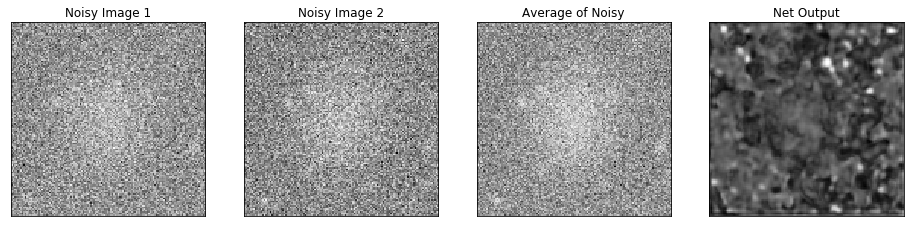

In [0]:
# Predicts noisy image 2 from noisy image 1, denoising the image
# Same as what is done in Training section above  
channels = test_data.get_full_batch(10)

noisy_images_1, noisy_images_2 = Tensor(channels[0]).unsqueeze(0).unsqueeze(0), Tensor(channels[1]).unsqueeze(0).unsqueeze(0)
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

output = model(noisy_images_1)
plot_tensors([noisy_images_1,
              noisy_images_2,
              0.5*(noisy_images_1 + noisy_images_2),
              output],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

(array([ 401., 4758., 7263., 3083.,  601.,  147.,   61.,   38.,   20.,
          12.]),
 array([-0.19956446,  0.05980754,  0.31917953,  0.57855153,  0.8379235 ,
         1.0972955 ,  1.3566675 ,  1.6160395 ,  1.8754115 ,  2.1347835 ,
         2.3941555 ], dtype=float32),
 <a list of 10 Patch objects>)

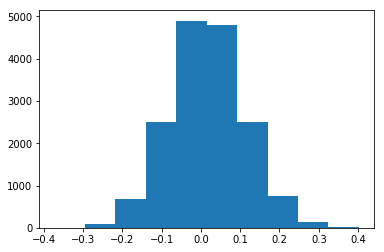

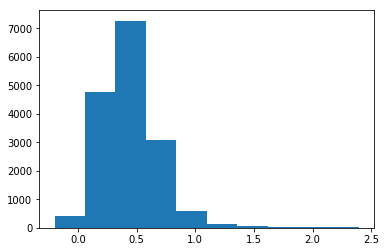

In [0]:
plt.hist(noisy_images_1.cpu().numpy().ravel())
plt.figure()
plt.hist(output.detach().cpu().numpy().ravel())